# Customer Retention Rates: Part 2 of Store Analysis
#### by ***Wayne Omondi***

## 1.0: Introduction

One of the best things for any business is to establish returning customers. Any company that wants to succeed must keep a close eye on its customer retention metrics. There’s a simple, economic reason why customer retention is so important: Keeping your existing customers is a lot less expensive than trying to win new ones. Loyal customers also contribute to your business’ health by providing referrals, promoting your brand on social media, and giving feedback to improve your product or service. So, it’s critical for companies to keep an eye on their customer retention rate.

***How do you calculate customer retention rate?***<br>
To determine our retention rate, first we have to identify the time frame you want to study. Next, collect the number of existing customers at the start of the time period. Then find the number of total customers at the end of the time period.

For this we will explore the concept of a ***cohort***. A cohort is <ins>a group of subjects that share a defining characteristic.</ins> 
>A cohort has three main attributes:
>1. time
>2. size
>3. behaviour

### 1.1: Steps

1. __Data Loading and Preparation__
2. __Assigning Cohorts__
3. __Creating Our Index__
4. __Visualization__
5. __Interpretation__

## 2.0: Data Loading and Prep

### 2.1: Libraries and Kernel Settings

First we import the libraries we will need to use for data loading and preparation and for the visualizations.

In [1]:
import pandas as pd #for data processing 
import matplotlib.pyplot as plt #plotting lib
import seaborn as sns #plotting lib

In [2]:
import datetime as dt #since we will be working with dates

Enable our notebook to ignore all warnings

In [3]:
import warnings
warnings.filterwarnings("ignore") 

We will use the SuperStore dataset from [Part 1. EDA Project](https://github.com/WayneNyariroh/StoreSales_Analysis)<br>
Let's import our dataset using read_csv()

### 2.2: Our Data

In [4]:
store_df = pd.read_csv(r"C:\Users\FatherMammoth\Documents\PortfolioPorjects\SalesAnalysis\data\SuperStoreSales_Whole.csv")

In [5]:
store_df.info() #see our rows, columns, non-null values and datatypes

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9800 entries, 0 to 9799
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Row ID         9800 non-null   int64  
 1   Order ID       9800 non-null   object 
 2   Order Date     9800 non-null   object 
 3   Ship Date      9800 non-null   object 
 4   Ship Mode      9800 non-null   object 
 5   Customer ID    9800 non-null   object 
 6   Customer Name  9800 non-null   object 
 7   Segment        9800 non-null   object 
 8   Country        9800 non-null   object 
 9   City           9800 non-null   object 
 10  State          9800 non-null   object 
 11  Postal Code    9789 non-null   float64
 12  Region         9800 non-null   object 
 13  Product ID     9800 non-null   object 
 14  Category       9800 non-null   object 
 15  Sub-Category   9800 non-null   object 
 16  Product Name   9800 non-null   object 
 17  Sales          9800 non-null   float64
 18  Quantity

After seeing our columns, we do not need a good number of them. The two most important columns for our cohort analysis are the *Order Date* and *Customer ID*. As such we have to check for any missing values in those two column.

In [6]:
store_df[['Order ID','Order Date','Customer ID','Sales']].isnull().sum()

Order ID       0
Order Date     0
Customer ID    0
Sales          0
dtype: int64

Let's create a new dataframe that has only the columns we need

In [7]:
customer_df = store_df[['Order ID','Order Date','Customer ID','Sales']] #the columns our new dataframe customer_df will have

In [8]:
customer_df.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9800 entries, 0 to 9799
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Order ID     9800 non-null   object 
 1   Order Date   9800 non-null   object 
 2   Customer ID  9800 non-null   object 
 3   Sales        9800 non-null   float64
dtypes: float64(1), object(3)
memory usage: 306.4+ KB


In [9]:
customer_df

,Order ID,Order Date,Customer ID,Sales
0,CA-2017-152156,8/11/2017,CG-12520,261.9600
1,CA-2017-152156,8/11/2017,CG-12520,731.9400
2,CA-2017-138688,12/6/2017,DV-13045,14.6200
3,US-2016-108966,11/10/2016,SO-20335,957.5775
4,US-2016-108966,11/10/2016,SO-20335,22.3680
...,...,...,...,...
9795,CA-2017-125920,21/05/2017,SH-19975,3.7980
9796,CA-2016-128608,12/1/2016,CS-12490,10.3680
9797,CA-2016-128608,12/1/2016,CS-12490,235.1880
9798,CA-2016-128608,12/1/2016,CS-12490,26.3760


Our dataset has 9800 entries that translates to 9800 purchases by cutsomers. Each purchase (*Order ID*) has a corresponding Customer ID. Let's see how many unique customer IDs we have in our dataset

In [10]:
customer_df['Customer ID'].nunique() #total unique values

793

793 Customers are responsible for the 9800 Orders. This indicticative of returning customers. In the tail of our dataframe above, we can observe that Customer ID CS-12490 is responsible for orders in entries 9796 to 9799.

Let's see how many times a customer's id appears in our dataframe, and an indicator of how many orders they made with the store for the time period in the dataset

Lets check the customers how have made the most orders (top 20)

In [11]:
customer_df['Customer ID'].value_counts().head(20)

WB-21850    35
MA-17560    34
PP-18955    34
JL-15835    33
CK-12205    32
JD-15895    32
SV-20365    32
EP-13915    31
ZC-21910    31
AP-10915    31
LC-16870    30
KL-16645    29
BM-11650    29
GT-14710    29
Dp-13240    29
CS-12250    28
XP-21865    28
KD-16495    28
CL-12565    28
KM-16720    28
Name: Customer ID, dtype: int64

## 3.0: Assigning Cohorts

As stated in the introduction the whole idea behind customer retention is having repeat purchases from that same client and a cohort being a group of subjects with a defining characteristics. In our case a customer cohort will be composed of all the customers who made their first purchase with the store on a given time period. For that we need to create new columns - Year, Order Month, Cohort Month aka Month of Customer Acquisition -  that will need to be in datetime format for easy date manipulation. We will also need to call on datetime library's methods for this. And we will need to get the time offsets.

In [12]:
customer_df #a quick look at our dataframe as it currently is

,Order ID,Order Date,Customer ID,Sales
0,CA-2017-152156,8/11/2017,CG-12520,261.9600
1,CA-2017-152156,8/11/2017,CG-12520,731.9400
2,CA-2017-138688,12/6/2017,DV-13045,14.6200
3,US-2016-108966,11/10/2016,SO-20335,957.5775
4,US-2016-108966,11/10/2016,SO-20335,22.3680
...,...,...,...,...
9795,CA-2017-125920,21/05/2017,SH-19975,3.7980
9796,CA-2016-128608,12/1/2016,CS-12490,10.3680
9797,CA-2016-128608,12/1/2016,CS-12490,235.1880
9798,CA-2016-128608,12/1/2016,CS-12490,26.3760


In order to freely dates we have to make sure our columns of interest is in the right datatype

In [13]:
customer_df.dtypes #check dataframe's data types

Order ID        object
Order Date      object
Customer ID     object
Sales          float64
dtype: object

The Order Date column is a string object, we have to change it to datetime. For that we use the to_datetime() method

In [14]:
customer_df['Order Date'] = pd.to_datetime(customer_df['Order Date']) #change Order Date column to datetime datatype
customer_df['Year'] = customer_df['Order Date'].dt.year #lets create a column for year to later allow us to select a year to focus on

In [15]:
def getmonth(x): #create a function that when called returns a date in form of year, month and first
    return dt.datetime(x.year, x.month,1)

customer_df['Order Month'] = customer_df['Order Date'].apply(getmonth) #create a new column that will contain the results of our getmonth() function
customer_df

,Order ID,Order Date,Customer ID,Sales,Year,Order Month
0,CA-2017-152156,2017-08-11,CG-12520,261.9600,2017,2017-08-01
1,CA-2017-152156,2017-08-11,CG-12520,731.9400,2017,2017-08-01
2,CA-2017-138688,2017-12-06,DV-13045,14.6200,2017,2017-12-01
3,US-2016-108966,2016-11-10,SO-20335,957.5775,2016,2016-11-01
4,US-2016-108966,2016-11-10,SO-20335,22.3680,2016,2016-11-01
...,...,...,...,...,...,...
9795,CA-2017-125920,2017-05-21,SH-19975,3.7980,2017,2017-05-01
9796,CA-2016-128608,2016-12-01,CS-12490,10.3680,2016,2016-12-01
9797,CA-2016-128608,2016-12-01,CS-12490,235.1880,2016,2016-12-01
9798,CA-2016-128608,2016-12-01,CS-12490,26.3760,2016,2016-12-01


In [16]:
customer_df['Cohort Month'] = customer_df.groupby('Customer ID')['Order Month'].transform('min') #determine the first month we see a Customer ID in our dataframe, the date we acquired them
customer_df.head(10) #check to see the first 10 entries in the df and the new cohort

,Order ID,Order Date,Customer ID,Sales,Year,Order Month,Cohort Month
0,CA-2017-152156,2017-08-11,CG-12520,261.9600,2017,2017-08-01,2016-10-01
1,CA-2017-152156,2017-08-11,CG-12520,731.9400,2017,2017-08-01,2016-10-01
2,CA-2017-138688,2017-12-06,DV-13045,14.6200,2017,2017-12-01,2017-09-01
3,US-2016-108966,2016-11-10,SO-20335,957.5775,2016,2016-11-01,2016-04-01
4,US-2016-108966,2016-11-10,SO-20335,22.3680,2016,2016-11-01,2016-04-01
5,CA-2015-115812,2015-09-06,BH-11710,48.8600,2015,2015-09-01,2015-09-01
6,CA-2015-115812,2015-09-06,BH-11710,7.2800,2015,2015-09-01,2015-09-01
7,CA-2015-115812,2015-09-06,BH-11710,907.1520,2015,2015-09-01,2015-09-01
8,CA-2015-115812,2015-09-06,BH-11710,18.5040,2015,2015-09-01,2015-09-01
9,CA-2015-115812,2015-09-06,BH-11710,114.9000,2015,2015-09-01,2015-09-01


## 4.0: Creating Our Index: Cohort Index

In [17]:
def date_elements (df, column):
    day = df[column].dt.day
    month = df[column].dt.month
    year = df[column].dt.year
    return day, month, year

_,FirstOrderMonth, FirstOrderYear = date_elements(customer_df, 'Order Month')
_,CohortMonth, CohortYear = date_elements(customer_df, 'Cohort Month')

FirstOrderMonth[:10]

0     8
1     8
2    12
3    11
4    11
5     9
6     9
7     9
8     9
9     9
Name: Order Month, dtype: int64

In [18]:
year_diff = FirstOrderYear - CohortYear
month_diff = FirstOrderMonth - CohortMonth

customer_df['CohortIndex'] = year_diff*12+month_diff+1 #adding +1 starts the index at 1 instead of 0

In [19]:
customer_df.tail()

,Order ID,Order Date,Customer ID,Sales,Year,Order Month,Cohort Month,CohortIndex
9795,CA-2017-125920,2017-05-21,SH-19975,3.798,2017,2017-05-01,2015-10-01,20
9796,CA-2016-128608,2016-12-01,CS-12490,10.368,2016,2016-12-01,2016-12-01,1
9797,CA-2016-128608,2016-12-01,CS-12490,235.188,2016,2016-12-01,2016-12-01,1
9798,CA-2016-128608,2016-12-01,CS-12490,26.376,2016,2016-12-01,2016-12-01,1
9799,CA-2016-128608,2016-12-01,CS-12490,10.384,2016,2016-12-01,2016-12-01,1


## 5.0: Visualizations

##### 2015 Retention Rates

In [20]:
#to focus on a year, we create a filter and use loc 
yearfilter = customer_df['Year'] == 2015
df_2015 = customer_df.loc[yearfilter]

In [21]:
cohort_df = df_2015.groupby(['Cohort Month', 'CohortIndex'])['Customer ID'].apply(pd.Series.nunique).reset_index()
cohort_df

,Cohort Month,CohortIndex,Customer ID
0,2015-01-01,1,54
1,2015-01-01,2,2
2,2015-01-01,3,6
3,2015-01-01,4,1
4,2015-01-01,5,6
...,...,...,...
73,2015-10-01,2,6
74,2015-10-01,3,6
75,2015-11-01,1,52
76,2015-11-01,2,6


In [22]:
cohort_table_2015 = cohort_df.pivot(index='Cohort Month', columns=['CohortIndex'], values='Customer ID') #create a pivot table

In [23]:
cohort_table_2015

CohortIndex,1,2,3,4,5,6,7,8,9,10,11,12
Cohort Month,,,,,,,,,,,,
2015-01-01,54.0,2.0,6.0,1.0,6.0,8.0,9.0,6.0,6.0,2.0,6.0,5.0
2015-02-01,44.0,5.0,6.0,3.0,4.0,4.0,1.0,5.0,4.0,3.0,7.0,NaN
2015-03-01,65.0,8.0,2.0,1.0,5.0,2.0,6.0,1.0,9.0,9.0,NaN,NaN
2015-04-01,44.0,3.0,1.0,2.0,4.0,6.0,4.0,8.0,7.0,NaN,NaN,NaN
2015-05-01,61.0,4.0,5.0,7.0,5.0,2.0,11.0,9.0,NaN,NaN,NaN,NaN
2015-06-01,48.0,4.0,1.0,5.0,2.0,8.0,6.0,NaN,NaN,NaN,NaN,NaN
2015-07-01,39.0,1.0,8.0,1.0,5.0,6.0,NaN,NaN,NaN,NaN,NaN,NaN
2015-08-01,46.0,9.0,2.0,7.0,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-09-01,52.0,3.0,4.0,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [24]:
cohort_table_2015.index = cohort_table_2015.index.strftime('%B %Y') #to fix the xaxis into month and year instead of time code, comment put on reruns

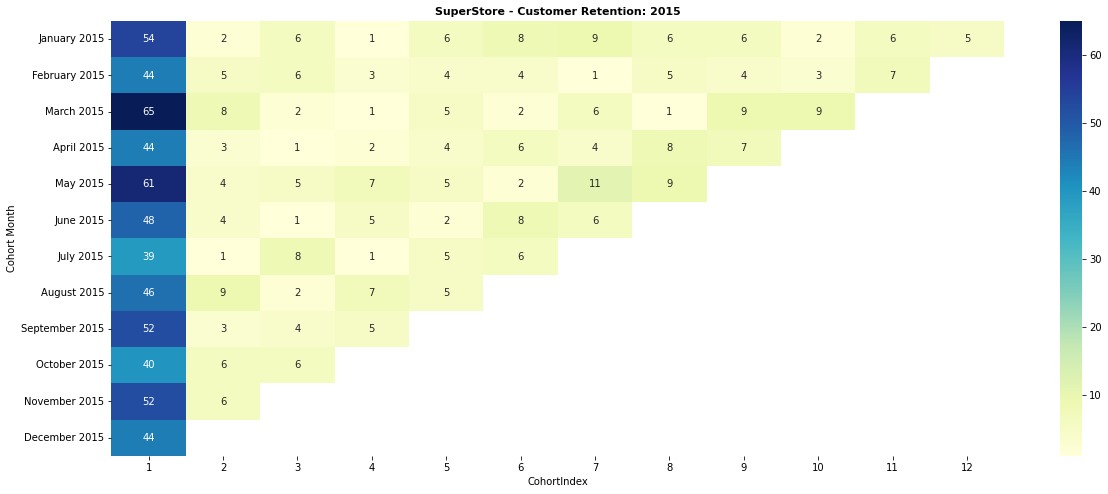

In [25]:
plt.figure(figsize=(20,8))
plt.title('SuperStore - Customer Retention: 2015',fontsize=11, fontweight='bold')
sns.heatmap(cohort_table_2015, annot=True, cmap='YlGnBu')
plt.show()

The yaxis shows the cohort months i.e, the month of the first order for each customers with the values in Cohort Index 1 showing the total number of customers that made their first order in that month - 54 customers made their first order in January 2015. Cohort Index 2 and forward show the subsequent months following when the month of the first order - of the 54 customers that made their first order in January 2015, 2 were returning customers in the following month and 5 returning customers at the 12 month.



To show Retention Rates as percentages

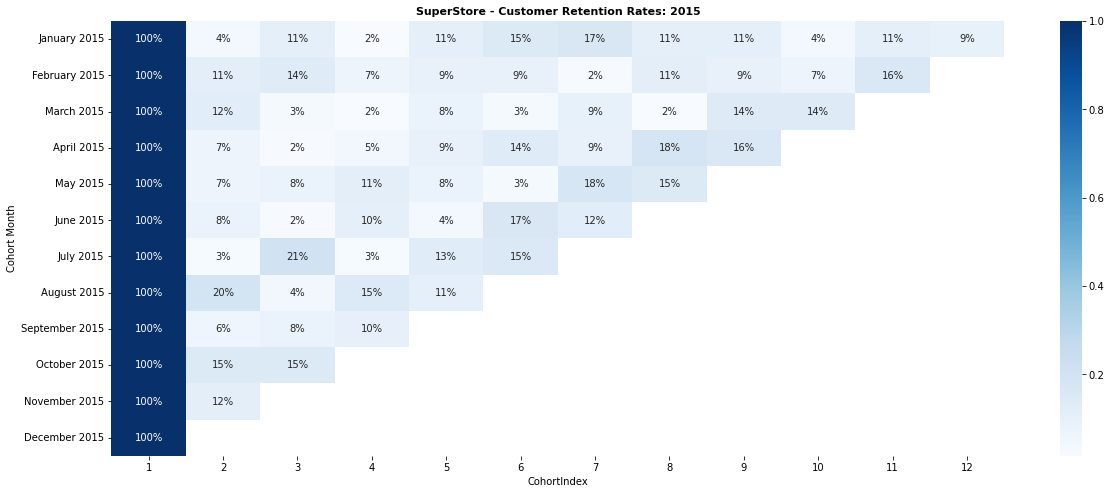

In [26]:
retention_rates_2015 = cohort_table_2015.divide(cohort_table_2015.iloc[:,0], axis=0) #divide each row by the first row aka month 1, add fmt='.0%' to plot attributes

plt.figure(figsize=(20,8))
plt.title('SuperStore - Customer Retention Rates: 2015',fontsize=11, fontweight='bold')
sns.heatmap(retention_rates_2015, annot=True, cmap='Blues', fmt='.0%')
plt.show()

### Next Step

Show revenue spents by each cohort plotted in the same format

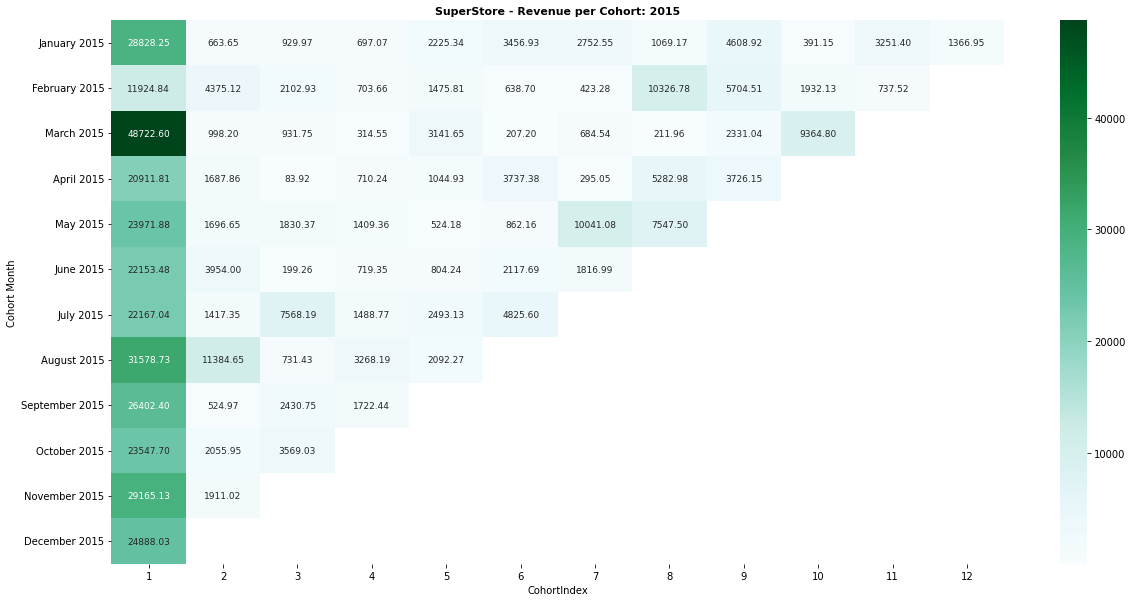

In [34]:
revenue_cohort_df = df_2015.groupby(['Cohort Month', 'CohortIndex'])['Sales'].apply(pd.Series.sum).round(2).reset_index()
revenue_table_2015 = revenue_cohort_df.pivot(index='Cohort Month', columns=['CohortIndex'], values='Sales')

revenue_table_2015.index = revenue_table_2015.index.strftime('%B %Y')

plt.figure(figsize=(20,10))
plt.title('SuperStore - Revenue per Cohort: 2015',fontsize=11, fontweight='bold')
sns.heatmap(revenue_table_2015, annot=True, annot_kws={"size":9}, cmap='BuGn', fmt='.2f')
plt.show()

In [28]:
revenue_table_2015

CohortIndex,1,2,3,4,5,6,7,8,9,10,11,12
Cohort Month,,,,,,,,,,,,
January 2015,28828.25,663.65,929.97,697.07,2225.34,3456.93,2752.55,1069.17,4608.92,391.15,3251.40,1366.95
February 2015,11924.84,4375.12,2102.93,703.66,1475.81,638.70,423.28,10326.78,5704.51,1932.13,737.52,NaN
March 2015,48722.60,998.20,931.75,314.55,3141.65,207.20,684.54,211.96,2331.04,9364.80,NaN,NaN
April 2015,20911.81,1687.86,83.92,710.24,1044.93,3737.38,295.05,5282.98,3726.15,NaN,NaN,NaN
May 2015,23971.88,1696.65,1830.37,1409.36,524.18,862.16,10041.08,7547.50,NaN,NaN,NaN,NaN
June 2015,22153.48,3954.00,199.26,719.35,804.24,2117.69,1816.99,NaN,NaN,NaN,NaN,NaN
July 2015,22167.04,1417.35,7568.19,1488.77,2493.13,4825.60,NaN,NaN,NaN,NaN,NaN,NaN
August 2015,31578.73,11384.65,731.43,3268.19,2092.27,NaN,NaN,NaN,NaN,NaN,NaN,NaN
September 2015,26402.40,524.97,2430.75,1722.44,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


when we look at the cohorts interms of Revenues, the 54 customers who made their first order in January 2015 spent 28828.25 in that first order month, a month later that cohort spent 636.65 and 5 months later (cohort index 6) they spent 3456.93